### Deforestation Detection Using Sentinel-1 SAR

GEOG 313: Advanced Geospatial w/ Python Final Project

In [1]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [2]:
start = "2015-01-01"
end = "2024-12-31"

In [36]:
import leafmap

m = leafmap.Map(center=[-5.0467299, 38.7375924], zoom=18, height="800px", google_map="SATELLITE")
#m.add_raster(mask)
m.add(aoi)
m

Map(center=[-5.0467299, 38.7375924], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [4]:
aoi = (m.west, m.south, m.east, m.north)

In [8]:
aoi = (38.73735040426255, -5.047439253672179, 38.73931780457497, -5.046370529620204)

In [11]:
import utils
preprocessed = utils.preprocess_data(aoi, start, end, deseason=True)
preprocessed

<xarray.DataArray 'stackstac-8652c5dd95757fb4f0fa886978794268' (time: 40, y: 7,
                                                                x: 12)> Size: 27kB
dask.array<getitem, shape=(40, 7, 12), dtype=float64, chunksize=(1, 6, 11), chunktype=numpy.ndarray>
Coordinates: (12/29)
  * x                            (x) float64 96B 4.709e+05 ... 4.711e+05
  * y                            (y) float64 56B 9.442e+06 ... 9.442e+06
  * time                         (time) datetime64[ns] 320B 2015-03-31 ... 20...
    band                         <U2 8B 'vh'
    sar:pixel_spacing_azimuth    int64 8B 10
    sat:orbit_state              <U9 36B 'ascending'
    ...                           ...
    sar:looks_azimuth            int64 8B 1
    sar:looks_equivalent_number  float64 8B 4.4
    raster:bands                 object 8B {'nodata': -32768, 'data_type': 'f...
    title                        <U41 164B 'VH: vertical transmit, horizontal...
    description                  <U173 692B 'Terrain-corrected gamma naught v...
    epsg                         int64 8B 32737

Attempt 1: error not being able to apply polyfit to windowed construct?  However, when looking at the structure of 'construct' it says it is a dataarray, wich should have attribute `dataarray.polyfit`

In [39]:
def linear_trend(stack):
    trend = stack.polyfit(dim = "time", deg = 1)
    return trend


rolling = preprocessed.rolling(time = 4, center = True)
construct = rolling.construct("window_dim")

construct.reduce(linear_trend)

AttributeError: 'Array' object has no attribute 'polyfit'

attempt 2: using np.polyfit. Here I get a similar error. This array should still have a time dimension?

In [38]:
import numpy as np

rolling = preprocessed.rolling(time = 3, center = True)
construct = rolling.construct("window_dim")

def linear_trend(x):
    pf = np.polyfit(x.time, x, 1)
    # need to return an xr.DataArray for groupby
    return xr.DataArray(pf[0])
    
construct.reduce(linear_trend)
 

AttributeError: 'Array' object has no attribute 'time'

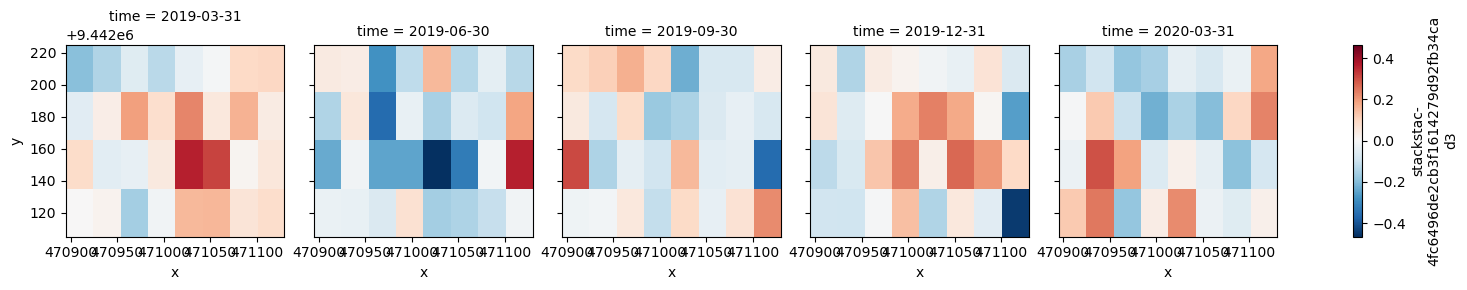

In [39]:

change = utils.img_change(deseasoned)
change.isel(time=[16, 17, 18, 19, 20]).plot.imshow(col="time", col_wrap=5)

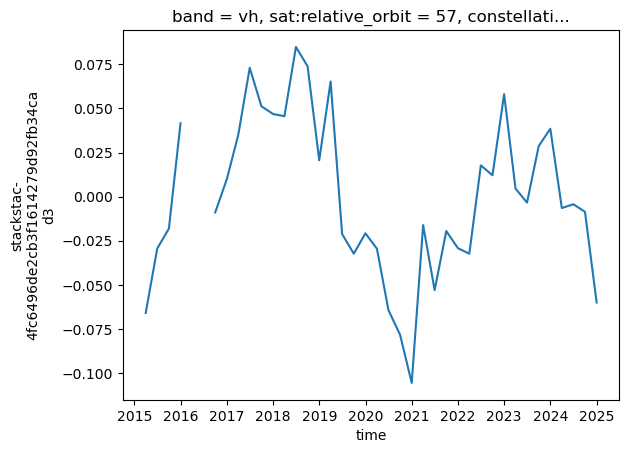

In [40]:
tsmean = deseasoned.mean(dim = ['y', 'x'], skipna = True)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
tsmean.plot(ax=ax)

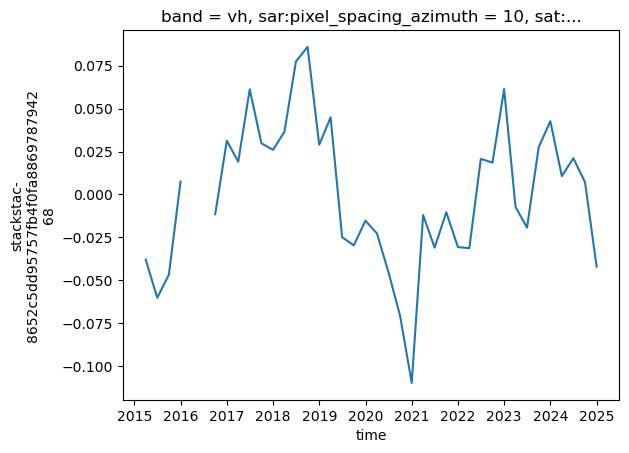

In [12]:
tsmean = preprocessed.mean(dim = ['y', 'x'], skipna = True)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
tsmean.plot(ax=ax)

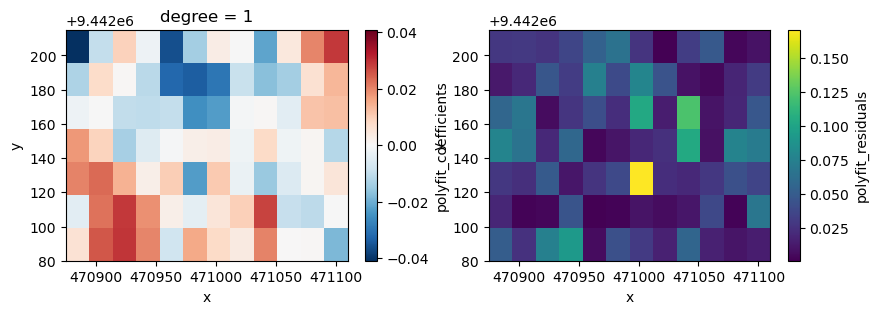

In [35]:
preprocessed = utils.preprocess_data(aoi, "2019-01-01", "2021-01-01", deseason=True)

preprocessed.coords['year'] = ('time', preprocessed.time.dt.year.data)

trend = preprocessed.polyfit(dim = "year", full = True, deg = 1)
linecoeff = trends.sel(degree = 1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(10,3))

linecoeff.polyfit_coefficients.plot.imshow(ax=ax[0])
trend.polyfit_residuals.plot.imshow(ax=ax[1])

In [ ]:
trends = utils.linear_trend(preprocessed)
linecoeff = trends.sel(degree = 1)

linecoeff.polyfit_coefficients.plot.imshow()

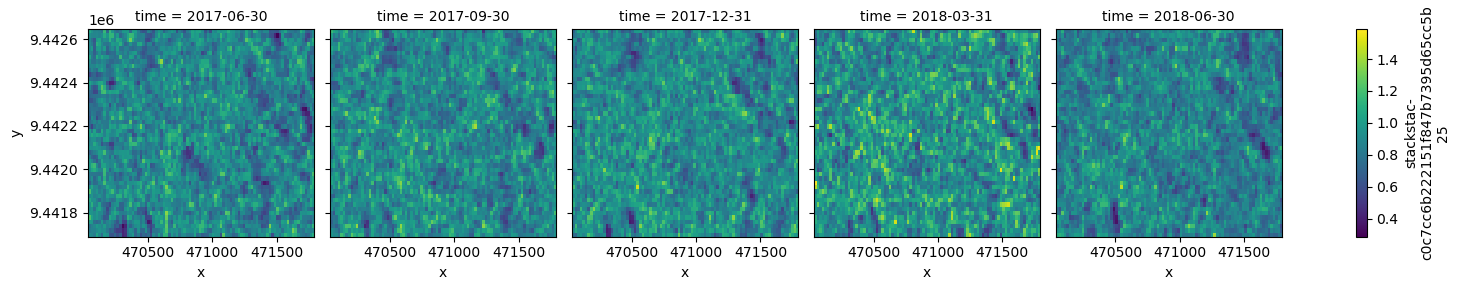

In [15]:
index = utils.calculate_index(composite, "RVI")
index.isel(time=[9, 10, 11, 12, 13]).plot.imshow(col="time", col_wrap=5)